# Forecasting II: state space models

This tutorial covers state space modeling with the [pyro.contrib.forecast](http://docs.pyro.ai/en/latest/contrib.forecast.html) module. This tutorial assumes the reader is already familiar with [SVI](http://pyro.ai/examples/svi_part_ii.html), [tensor shapes](http://pyro.ai/examples/tensor_shapes.html), and [univariate forecasting](http://pyro.ai/examples/forecasting_i.html).

#### Summary

- Pyro's [ForecastingModel]() can combine regression, variational inference, and exact inference.
- To model a linear-Gaussian dynamical system, use [GaussianHMM]() `noise_dist`.
- To model a heavy-tailed linear dynamical system, use [LinearHMM]() with a heavy-tailed distribution.
- To enable inference with [LinearHMM](), use a [LinearHMMReparam]() reparameterizer.

In [41]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

## Intro to state space models

In the [univariate tutorial](http://pyro.ai/examples/forecasting_i.html) we saw how to model time series through regression and local level, using variational inference. This tutorial covers a different way to model time series: state space models and exact inference. Pyro's forecasting module allows these two paradigms to be combined, for example modeling seasonality with regression, including a slow global trend, and using a state-space model for short-term local trend.

Pyro implements a few state space models, but the most important are the [GaussianHMM]() distribution and its heavy-tailed generalization the [LinearHMM]() distribution. Both of these model a linear dynamical system with hidden state; both are multivariate, and both allow learning of all process parameters. On top of these the [pyro.contrib.timeseries]() module implements a variety of multivariate Gaussian Process models that compile down to `GaussianHMM`s.

Pyro's inference for `GaussianHMM` uses parallel-scan Kalman filtering, allowing fast analysis of very long time series. Similarly, Pyro's inference for `LinearHMM` uses entirely parallel auxiliary variable methods to reduce to a `GaussianHMM` and then parallel-scan inference; thus both methods allow parallelization of long time series analysis even for univariate data.

Let's again look at the [BART train](https://www.bart.gov/about/reports/ridership) ridersip dataset:

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 1])


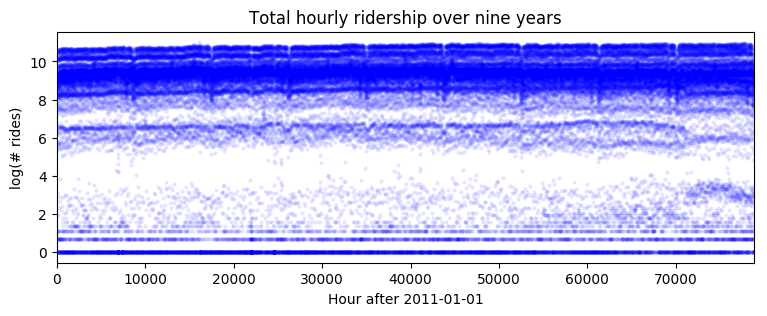

In [3]:
data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data, 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Total hourly ridership over nine years")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(0, len(data));

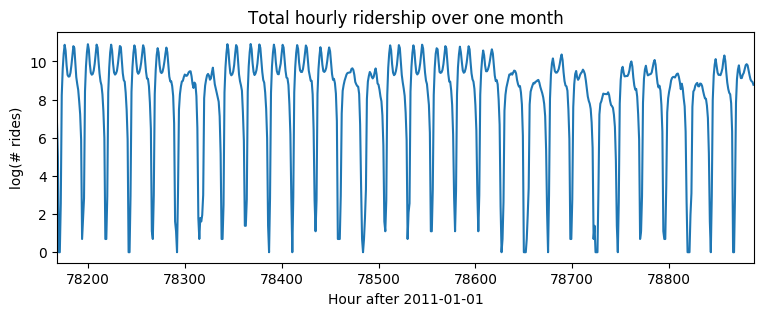

In [4]:
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

## GaussianHMM

Let's start by modeling weekly seasonality together with a local linear trend, where we model seasonality via regression and local linear trend via a `GaussianHMM`.

In [19]:
means = data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)

class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)

        # We'll hard-code the periodic part of this model, learning only the local model.
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [23]:
T0 = 0                # beginning
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split

We can then train the model on many years of data. Note that because we are being variational about only time-global variables, and exactly integrating out time-local variables (via `GaussianHMM`), gradients are very clean; this allows us to use a large learning rate and few steps.

In [22]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.878717
INFO 	 step  100 loss = 0.650493
INFO 	 step  200 loss = 0.650542
INFO 	 step  300 loss = 0.650579


timescale = 4.461
trans_scale = 0.4563
obs_scale = 0.0593
CPU times: user 25.6 s, sys: 1.25 s, total: 26.8 s
Wall time: 26.9 s


Plotting forecasts of the next two weeks of data, we see mostly reasonable forecasts, but an anomaly on Christmas when rides were overpredicted. This is to be expected, as we have ont modeled yearly seasonality or holidays.

torch.Size([100, 336, 1]) torch.Size([336])


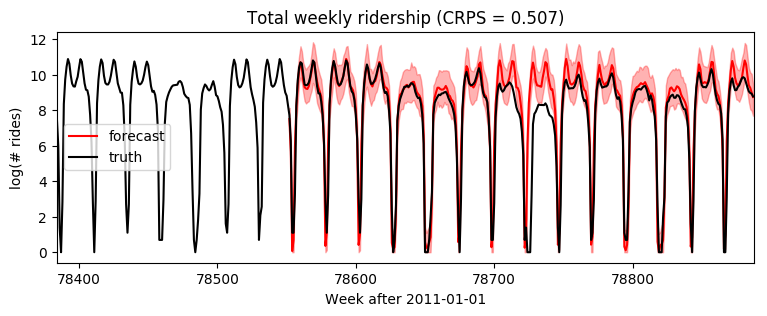

In [25]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.legend(loc="best");

Next let's change the model to use heteroskedastic observation noise, depending on the hour of week.

In [30]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.]])
        
        # To model heteroskedastic observatio noise, we'll sample obs_scale inside a plate,
        # then repeat to full duration. This is the only change.
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)
        
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [31]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.954783
INFO 	 step  100 loss = -0.0344435
INFO 	 step  200 loss = -0.0373581
INFO 	 step  300 loss = -0.0376129


timescale = 61.41
trans_scale = 0.1082
CPU times: user 26.9 s, sys: 1.51 s, total: 28.4 s
Wall time: 28.5 s


Note this gives us a much longer timescale and thereby more accurate short-term predictions:

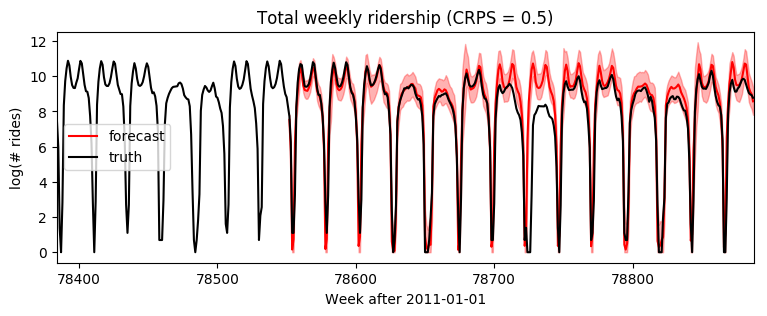

In [28]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.legend(loc="best");

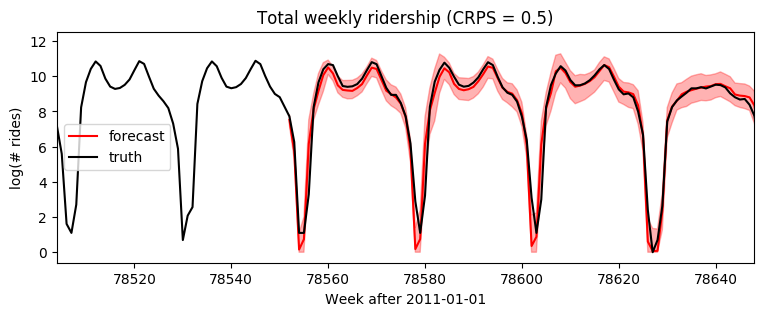

In [29]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");

## Heavy-tailed modeling with LinearHMM

Next let's change our model to a linear-[Stable]() dynamical system, exhibiting learnable heavy tailed behavior in both the process noise and observation noise. As we've already seen in the [univariate tutorial](), this will require special handling of stable distributions by [poutie.reparam()](). For state space models, we combine [LinearHMMReparam]() with other reparameterizers like [StableReparam]() and [SymmetricStableReparam](). All reparameterizers preserve behavior of the generative model, and only serve to enable inference via auxiliary variable methods.

In [51]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # First sample the Gaussian-like parameters as in previous models.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        obs_matrix = torch.tensor([[1.]])
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)
        
        # In addition to the Gaussian parameters, we will learn a global stability
        # parameter to determine tail weights, and an observation skew parameter.
        stability = pyro.sample("stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
    
        # Next we construct stable distributions and a linear-stable HMM distribution.
        trans_dist = dist.Stable(stability, 0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_dist = dist.Stable(stability, skew, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.LinearHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        
        # Finally we use a reparameterizer to enable inference.
        rep = LinearHMMReparam(None,                     # init_dist is already Gaussian.
                               SymmetricStableReparam(), # trans_dist is symmetric.
                               StableReparam())          # obs_dist is asymmetric.
        with poutine.reparam(config={"residual": rep}):
            self.predict(noise_dist, prediction)

In [52]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.05)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 42.9187


ValueError: The parameter loc has invalid values
              Trace Shapes:      
               Param Sites:      
  AutoNormal.locs.timescale      
AutoNormal.scales.timescale      
              Sample Sites:      
          hour_of_week dist     |
                      value 168 |